# Data-driven skills taxonomy

Goal: To build a data-driven skills taxonomy.

General approach taken: Finding hierarchical clustering of skills, based on the idea that certain skills co-occur more often in a certain context, here across occupations listed in the ESCO framework. Additionally use the similarity between skill descriptions as calculated using NLP tools. Once the skills are represented as a network with weighted edges according to these attributes, they can be hierarchically grouped into clusters using community detection algorithms.

Author: Maud Grol

## Set up

In [2]:
%autosave 120
%matplotlib inline

# import libraries
import sys
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import spacy
import string
import re
import nltk
import random
import igraph

nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from tqdm import trange
from igraph import Graph, compare_communities, drawing

Autosaving every 120 seconds


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mgrol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# settings: relevant files are assumed to be in same folder as Jupyter notebook
workdir = os.getcwd()
random.seed(42)

In [4]:
# load data
skills_df = pd.read_csv(os.path.join(workdir, 'skills_en.csv'))
occup_df = pd.read_csv(os.path.join(workdir, 'occupations_en.csv'))

with open(os.path.join(workdir, 'ESCO_occup_skills.json'),"r") as fp:
 esco_dict = json.load(fp)

## Data inspection

In [5]:
# check which columns are in the skills data, the number of rows/columns, and look at data.
print(f'Columns in skills data file: {list(skills_df.columns)}')
print(f'Shape of skills data file: {skills_df.shape}')
skills_df.head()

Columns in skills data file: ['conceptType', 'conceptUri', 'skillType', 'reuseLevel', 'preferredLabel', 'altLabels', 'description']
Shape of skills data file: (13485, 7)


,conceptType,conceptUri,skillType,reuseLevel,preferredLabel,altLabels,description
0,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/0005c151-5b5a...,skill/competence,sector-specific,manage musical staff,manage staff of music\ncoordinate duties of mu...,Assign and manage staff tasks in areas such as...
1,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/00064735-8fad...,skill/competence,occupation-specific,supervise correctional procedures,oversee prison procedures\nmanage correctional...,Supervise the operations of a correctional fac...
2,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/000709ed-2be5...,skill/competence,sector-specific,apply anti-oppressive practices,apply non-oppressive practices\napply an anti-...,"Identify oppression in societies, economies, c..."
3,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/0007bdc2-dd15...,skill/competence,sector-specific,control compliance of railway vehicles regulat...,monitoring of compliance with railway vehicles...,"Inspect rolling stock, components and systems ..."
4,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/00090cc1-1f27...,skill/competence,cross-sector,identify available services,establish available services\ndetermine rehabi...,Identify the different services available for ...


In [6]:
# check for missing data in skills data file
skills_df.isna().sum()

conceptType         0
conceptUri          0
skillType           0
reuseLevel          0
preferredLabel      0
altLabels         449
description         0
dtype: int64

In [7]:
# check which columns are in the occupation data, the number of rows/columns, and look at data.
print(f'Columns in occupation data file: {list(occup_df.columns)}')
print(f'Shape of occupation data file: {occup_df.shape}')
occup_df.head()

Columns in occupation data file: ['conceptType', 'conceptUri', 'iscoGroup', 'preferredLabel', 'altLabels', 'description']
Shape of occupation data file: (2942, 6)


,conceptType,conceptUri,iscoGroup,preferredLabel,altLabels,description
0,Occupation,http://data.europa.eu/esco/occupation/00030d09...,2166,technical director,technical and operations director\nhead of tec...,Technical directors realise the artistic visio...
1,Occupation,http://data.europa.eu/esco/occupation/000e93a3...,8121,metal drawing machine operator,metal drawing machine technician\nmetal drawin...,Metal drawing machine operators set up and ope...
2,Occupation,http://data.europa.eu/esco/occupation/0019b951...,7543,precision device inspector,inspector of precision instruments\nprecision ...,Precision device inspectors make sure precisio...
3,Occupation,http://data.europa.eu/esco/occupation/0022f466...,3155,air traffic safety technician,air traffic safety electronics hardware specia...,Air traffic safety technicians provide technic...
4,Occupation,http://data.europa.eu/esco/occupation/002da35b...,2431,hospitality revenue manager,hospitality revenues manager\nyield manager\nh...,Hospitality revenue managers maximise revenue ...


In [8]:
# check for missing data in occupation data file
occup_df.isna().sum()

conceptType        0
conceptUri         0
iscoGroup          0
preferredLabel     0
altLabels         39
description        0
dtype: int64

In [9]:
# function to check if (nested) keys exist in dictionary 
def keys_exists(element, *keys):
    '''
    Check if *keys (nested) exists in `element` (dict).
    '''
    if type(element) is not dict:
        raise AttributeError('keys_exists() expects dict as first argument.')
    if len(keys) == 0:
        raise AttributeError('keys_exists() expects at least two arguments, one given.')

    _element = element
    for key in keys:
        try:
            _element = _element[key]
        except KeyError:
            return False
    return True

In [10]:
# get nested list with all essential skill labels per occupation
occupation_list = list(esco_dict.keys())
occup_skill_list=[]

for id in occupation_list:
    temp_list=[]
    if keys_exists(esco_dict, id, "_links", "hasEssentialSkill") == True:
        nr_elements = len(esco_dict[id]['_links']['hasEssentialSkill'])
        for i in np.arange(0,nr_elements):
            temp_list.append(esco_dict[id]['_links']['hasEssentialSkill'][i]['title'])
    occup_skill_list.append(temp_list)

In [11]:
# check how many unique essential skills are listed across all occupations
ess_skill_list = []

#flatten the list
for x in occup_skill_list:
    for y in x:
        ess_skill_list.append(y)

print(f'There are {len(Counter(ess_skill_list).keys())} unique essential skills listed across all occupations.')

There are 10538 unique essential skills listed across all occupations.


In [12]:
# check how many skills are listed in skills data file
skills_list = skills_df['preferredLabel']
print(f'There are {len(skills_list)} skills described in the ESCO framework.')
print(f'This means that {len(skills_list)-len(Counter(ess_skill_list).keys())} skills are never listed as \
essential skills for any occupation.')

There are 13485 skills described in the ESCO framework.
This means that 2947 skills are never listed as essential skills for any occupation.


In [13]:
# get nested lists with all optional skill labels per occupation that have optional skills listed
optional_skill_list=[]
for id in occupation_list:
    temp_list=[]
    if keys_exists(esco_dict, id, "_links", "hasOptionalSkill") == True:
        nr_elements = len(esco_dict[id]['_links']['hasOptionalSkill'])
        for i in np.arange(0,nr_elements):
            temp_list.append(esco_dict[id]['_links']['hasOptionalSkill'][i]['title'])
    optional_skill_list.append(temp_list)

In [14]:
# join the essential and optional skills listed for each occupation
tot_occup_skill_list = [a + b for a, b in zip(occup_skill_list, optional_skill_list)]
len(tot_occup_skill_list)

2942

In [15]:
# check how many unique essential + optional skills are listed across all occupations
uni_occup_skill_list = []

#flatten the list
for x in tot_occup_skill_list:
    for y in x:
        uni_occup_skill_list.append(y)

uni_occup_skill_list = list(set(uni_occup_skill_list))        
        
print(f'There are {len(uni_occup_skill_list)} unique skills listed across all occupations.')
print(f'This means that {len(skills_list)-len(uni_occup_skill_list)} skills from the ESCO framework are never \
listed as either essential or optional skills for any occupation.')

There are 12572 unique skills listed across all occupations.
This means that 913 skills from the ESCO framework are never listed as either essential or optional skills for any occupation.


Looking through the lists below it seems that mostly (spoken) languages are mentioned as skills in the ESCO framework, but these are apparently not mentioned as either essential or optional skills for occupations in the ISCO system. Some other skills, such as "SQL" are not listed as skills under occupations, but "MySQL", "PostgreSQL" are. Other examples are that "Adobe Photoshop Lightroom" is never mentioned with any occupation, but "Adobe Photoshop" and "Adobe Illustrator" are, or that "JavaScript Framework" is never mentioned with any occupation, but "Java (computer programming)" and "JavaScript" are.

One could focus on creating a skills taxonomy based on all 'theoretically' possible skills, but if a skills taxonomy is to have some practical application, such as informing people on the labour market about skills needed by workers, then focusing on (essential and optional) skills listed with occupations will be more useful.

In [140]:
# check skills listed as essential or optional for occupations
sorted(uni_occup_skill_list)

['3D body scanning technologies',
 '3D lighting',
 '3D modelling',
 '3D printing process',
 '3D texturing',
 'ABAP',
 'ABBYY FineReader',
 'AJAX',
 'APL',
 'ASP.NET',
 'ATM systems',
 'Adobe Illustrator',
 'Adobe Photoshop',
 'Agile development',
 'Agile project management',
 'Android (mobile operating systems)',
 'Ansible',
 'Apache Maven',
 'Arabic',
 'Assembly (computer programming)',
 'Assertiveness',
 'Bible texts',
 'BlackBerry',
 'Brightspace (learning management systems)',
 'Buddhism',
 'C#',
 'C++',
 'CA Datacom/DB',
 'CAD for footwear',
 'CAD for garment manufacturing',
 'CAD software',
 'CADD software',
 'CAE software',
 'CAM software',
 'COBOL',
 'CSS',
 'Christianity',
 'Cisco',
 'Code of Conduct for Responsible Fisheries',
 'CoffeeScript',
 'Common Lisp',
 'CryEngine',
 'DB2',
 'DevOps',
 'Earth science',
 'Eclipse (integrated development environment software)',
 'Engrade',
 'Erlang',
 'European Train Control System',
 'European firearms-control legislation',
 'European p

In [141]:
# check which are the skills never mentioned as either essential or optional skills for occupations
not_occup_skill_list = np.setdiff1d(skills_list,uni_occup_skill_list)
sorted(not_occup_skill_list)

['Absorb (learning management systems)',
 'Adobe Photoshop Lightroom',
 'Aircrack (penetration testing tool)',
 'Ajax Framework',
 'Albanian',
 'Ancient Greek',
 'Apache Tomcat',
 'Armenian',
 'Azerbaijani',
 'Backbox (penetration testing tool)',
 'Basque',
 'Belarusian',
 'Bengali',
 'Berber',
 'Bihari',
 'BlackArch',
 'Bosnian',
 'Bulgarian',
 'Cain and Abel (penetration testing tool)',
 'Canvas (learning management systems)',
 'Capture One',
 'Catalan',
 'Chef (tools for software configuration management)',
 'Chinese',
 'Codenvy',
 'Croatian',
 'Czech',
 'Danish',
 'Drupal',
 'Dutch',
 'Edmodo',
 'English',
 'Estonian',
 'Finnish',
 'French',
 'Galician',
 'GameSalad',
 'Gamemaker Studio',
 'Georgian',
 'German',
 'Greek',
 'Grovo',
 'Gujarati',
 'Hadoop',
 'Havok Vision',
 'HeroEngine',
 'Hindi',
 'Hungarian',
 'IBM WebSphere',
 'Icelandic',
 'Irish',
 'Italian',
 'Japanese',
 'JavaScript Framework',
 'Javanese',
 'Jboss',
 'John The Ripper (penetration testing tool)',
 'Joomla',
 

In [18]:
# link relevant skills with their description
final_skills_df = pd.DataFrame(uni_occup_skill_list, columns=['skill_label'])

final_skills_df = pd.merge(final_skills_df, skills_df[['preferredLabel', 'description']], how='left', 
                    left_on='skill_label', right_on='preferredLabel')

# if 'skill_label' labels are the same as in 'preferredLabel', drop latter column
if final_skills_df['skill_label'].equals(final_skills_df['preferredLabel']) == True:
    final_skills_df.drop(columns=['preferredLabel'], inplace=True)

# save data file for potential re-use
final_skills_df.to_csv("final_skills.csv",index=False)    
        
final_skills_df.head()

,skill_label,description
0,undertake continuous professional development ...,Undertake continuous professional development ...
1,monitor temperature in farinaceous processes,Monitor and control the temperature in the dif...
2,report on voting process,Speak with election officials about the voting...
3,facilitate access to information,Prepare documents for archiving; ensure that t...
4,operate pumps,Operate industrial pumps used to remove excess...


## Text cleaning

Data cleaning steps before converting text to machine readable code:
* removing numbers except "2" and "3", because 2D and 3D may be meaningful terms from skill descriptions
* removing extra spaces
* tokenization
* lemmatisation
* removing stopwords
* removing punctuation

In [19]:
# load spaCy English language model, to create tokenized version of text
nlp = spacy.load("en_core_web_sm")

# create list of punctuations and stopwords
symbols = " ".join(string.punctuation).split(" ") + ['°','-', '..', '...', "”", "”", "----------------",
                                                     "):", '’', '’s', '—',""]

stopwrdlist = stopwords.words('english')
stopwrdlist += ["'ll", "'s", "e.g."]

In [20]:
# function to clean text: tokenization, lemmatisation, remove extra spaces, stopwords and punctuation
def cleanup_text(docs, logging=True):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = re.sub('[0,1,4,5,6,7,8,9]+', ' ', doc)
        doc = re.sub(' +',' ', doc)
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwrdlist and tok not in symbols]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

In [21]:
# create list of skills descriptions (corpus) and clean text
skills_text = [text for text in final_skills_df['description']]
skills_clean = cleanup_text(skills_text)

Processed 1000 out of 12572 documents.
Processed 2000 out of 12572 documents.
Processed 3000 out of 12572 documents.
Processed 4000 out of 12572 documents.
Processed 5000 out of 12572 documents.
Processed 6000 out of 12572 documents.
Processed 7000 out of 12572 documents.
Processed 8000 out of 12572 documents.
Processed 9000 out of 12572 documents.
Processed 10000 out of 12572 documents.
Processed 11000 out of 12572 documents.
Processed 12000 out of 12572 documents.


In [22]:
skills_clean[0:10]

0    undertake continuous professional development ...
1    monitor control temperature different phase fa...
2    speak election official voting process report ...
3    prepare document archiving ensure information ...
4     operate industrial pump use remove excess liquid
5    engage cooperate codification process order st...
6    oversee warehouse activity storage receipt dis...
7                  impact war experience mental health
8    stand watch ship bow stern bridge wing look ob...
9    maintain update statutory book company relevan...
dtype: object

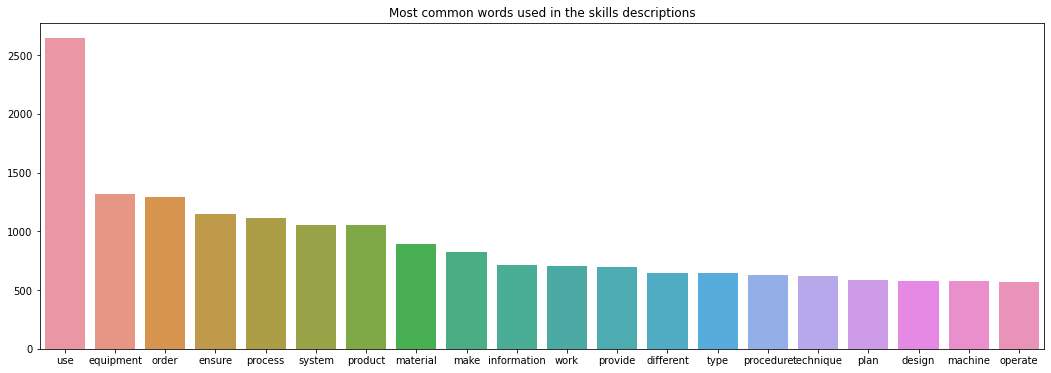

In [23]:
# visualize top words used in the skill descriptions for exploration purposes
skills_clean_words = ' '.join(skills_clean).split()
skills_counts = Counter(skills_clean_words)
skills_common_words = [word[0] for word in skills_counts.most_common(20)]
skills_common_counts = [word[1] for word in skills_counts.most_common(20)]

fig = plt.figure(figsize=(18,6))
sns.barplot(x=skills_common_words, y=skills_common_counts)
plt.title('Most common words used in the skills descriptions')
plt.show()

## TF-IDF vectorization and document similarity

TF-IDF and Word Embedding are two of the most common methods in NLP to convert sentences to machine readable code. But to train own model for word embeddings would require a lot of data and is memory intensive. One option would be to use a pretrained model but results may not be optimal in case of a specialized vocabulary. Decision was therefore made to use TF-IDF vectorization here, which transforms a document by counting the number of times each word in the vocabulary appears in the document. The weight of each word is normalized by the number of times it appears in the corpus.

In [24]:
# function to tokenize and clean text for use in TF-IDF vectorizer
def tokenizeText(sample):
    sample = re.sub('[0,1,4,5,6,7,8,9]+', ' ', sample)
    sample = re.sub(' +',' ', sample)
    tokens = nlp(sample)
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas
    tokens = [tok for tok in tokens if tok not in stopwrdlist]
    tokens = [tok for tok in tokens if tok not in symbols]
    return tokens

In [25]:
# define vectorizer parameters and fit to skills_text
"""
max_df: if the term is in more than 75% of the documents it probably carries little meanining in the context of 
skill descriptions.
max_features: max features to include in vocabulary, left unlimited here (but set min_df).
min_df: term has to be in at least 2 of the documents to be considered.
ngram_range: consider unigrams and bigrams.

"""

tfidf = TfidfVectorizer(max_df=0.75, max_features=None, min_df=2, use_idf=True, tokenizer=tokenizeText, ngram_range=(1,2))

%time tfidf_matrix = tfidf.fit_transform(skills_text)

terms = tfidf.get_feature_names() # vocabulary

print(tfidf_matrix.shape)

Wall time: 1min 21s
(12572, 25213)


In [136]:
# inspect vocabulary
print(terms)

['/2', '/3', '/3 /ec', '/ec', '2', '2 /3', '2 c', '2/2', '2d', '2d 3d', '2d computer', '2d flat', '2d raster', '2d vector', '3', '3 kg', '3d', '3d body', '3d computer', '3d environment', '3d image', '3d model', '3d printer', '3d printing', '3d scan', '3d volume', 'abandon', 'abandon ship', 'abattoir', 'abbreviation', 'abidance', 'abide', 'abide regulation', 'ability', 'ability identify', 'ability indicate', 'ability interact', 'ability make', 'ability need', 'ability preference', 'ability product', 'ability use', 'ability work', 'able', 'able calculate', 'able check', 'able convert', 'able develop', 'able draw', 'able form', 'able measure', 'able operate', 'able prepare', 'able produce', 'able read', 'able understand', 'able use', 'abnormal', 'abnormal behaviour', 'abnormal fish', 'abnormality', 'abortion', 'abrasive', 'abrasive blast', 'abrasive blasting', 'abrasive machine', 'abrasive material', 'abreast', 'abroad', 'absence', 'absorb', 'absorbent', 'absorbent material', 'absorption'

In [27]:
# calculate cosine similarity between skills descriptions
"""
Cosine similarity measures similarity between each document and the other documents in the corpus, 
irrespective of their size. Data type was set to float32 to save memory, but should give enough precision.

"""
similarity = cosine_similarity(tfidf_matrix).astype(np.float32)
print(similarity.shape)

(12572, 12572)


## Building taxonomy

### Calculate relevant data

In [28]:
# create co-occurence matrix for weighted edges based on co-occurrence frequence: all possible combinations of skills
u = pd.get_dummies(pd.DataFrame(tot_occup_skill_list), prefix='', prefix_sep='').sum(level=0, axis=1)
v = u.T.dot(u)

v = v.astype('float64')
v_upper = v.copy()
# set NaN to lower triangular matrix because of creating an undirected graph
v_upper.values[np.tril(np.ones(v_upper.shape)).astype(np.bool)] = np.nan
# set 0 to NaN because of memory issues, but here weight of 0 would imply no edge (i.e. no co-occurence) 
v_upper.replace(to_replace=0, value=np.nan,inplace=True)
v_upper.shape

(12572, 12572)

In [29]:
# reshape and filter 'missing' values
a = v_upper.stack(dropna=True)
co_occur_df=a.to_frame()
co_occur_df.reset_index(inplace=True, drop=False)
co_occur_df.columns = ['skill1','skill2','co_occur_freq']

In [ ]:
# load previously saved file for co-occurence data
co_occur_df = pd.read_csv(os.path.join(workdir, 'co_occurrence_skills.csv'))

In [30]:
# inspect data file
print(co_occur_df.shape)
co_occur_df.head()

(1317539, 3)


,skill1,skill2,co_occur_freq
0,CAD for garment manufacturing,adhere to organisational guidelines,1.0
1,CAD for garment manufacturing,advise customers on sewing patterns,1.0
2,CAD for garment manufacturing,analyse supply chain strategies,4.0
3,CAD for garment manufacturing,apparel manufacturing technology,10.0
4,CAD for garment manufacturing,apply health and safety standards,1.0


Get the cosine similarity for each skill with the 500 other skills with which it has the highest similarity.  

In [31]:
# get relevant variables to create data frame for weighted edges based on cosine similarity
skills_labels = final_skills_df['skill_label']

In [32]:
%%time
# create data frame for weighted edges based on cosine similarity: for 500 most similar skills 
i = 0
skill_cs_frame = []
for cs, z in zip(similarity, trange(len(skills_labels))):
    # Create vector of skills labels
    start_name = pd.Series([skills_labels[i]]*501)
    # Index of top 501 similar skills (500+similarity with itself)
    ix_top_n = np.argsort(-cs)[0:501]
    cos_sim = pd.Series(cs[ix_top_n])
    names = pd.Series(skills_labels[ix_top_n]).reset_index(drop=True)
    i +=1
    skill_cs_frame.append(pd.DataFrame(list(zip(start_name, names, cos_sim))))

skill_cs_df = pd.concat(skill_cs_frame)
skill_cs_df.columns = ['skill1', 'skill2', 'cos_sim']
# Remove the cosine similarities of skills with themselves
skill_cs_df['is_same'] = [bool(i==j) for i, j in zip(skill_cs_df['skill1'], skill_cs_df['skill2'])]
skill_cs_df = skill_cs_df[skill_cs_df['is_same'] != True]
skill_cs_df.reset_index(drop=True, inplace=True)

100%|█████████▉| 12571/12572 [00:33<00:00, 376.85it/s]


Wall time: 37.8 s


In [33]:
# remove duplicates where skill A & skill B == skill B & skill A because of undirected graph
out = pd.Series(map(frozenset,zip(skill_cs_df['skill1'],skill_cs_df['skill2'])))
skill_cs_df['duplicates']=out
skill_cs_df.drop_duplicates(subset=['duplicates'], inplace=True)
skill_cs_df.drop(columns=['duplicates', 'is_same'],inplace=True)
print(skill_cs_df.shape)
skill_cs_df.head()

(3810463, 3)


,skill1,skill2,cos_sim
0,undertake continuous professional development ...,accept own accountability,0.356539
1,undertake continuous professional development ...,manage personal professional development,0.355552
2,undertake continuous professional development ...,teach principles of social work,0.343753
3,undertake continuous professional development ...,manage personal professional development in sport,0.321573
4,undertake continuous professional development ...,apply context specific clinical competences,0.296795


In [ ]:
# load previously saved file for cosine similarity data
skill_cs_df = pd.read_csv(os.path.join(workdir, "cos_similarity_skills.csv"))

In [34]:
# combine the co-occurence and cosine similarity data for graph building from dataframe
graph_df = pd.merge(co_occur_df, skill_cs_df, how='outer', left_on=["skill1", "skill2"], right_on=["skill1","skill2"])

graph_df.fillna(0, inplace=True) # fill 'missing' data with 0 (i.e. edge weight of 0)
out = pd.Series(map(frozenset,zip(graph_df['skill1'],graph_df['skill2'])))
graph_df['duplicates']=out
graph_df.head()

,skill1,skill2,co_occur_freq,cos_sim,duplicates
0,CAD for garment manufacturing,adhere to organisational guidelines,1.0,0.0,"(adhere to organisational guidelines, CAD for ..."
1,CAD for garment manufacturing,advise customers on sewing patterns,1.0,0.0,"(advise customers on sewing patterns, CAD for ..."
2,CAD for garment manufacturing,analyse supply chain strategies,4.0,0.0,"(analyse supply chain strategies, CAD for garm..."
3,CAD for garment manufacturing,apparel manufacturing technology,10.0,0.0,"(apparel manufacturing technology, CAD for gar..."
4,CAD for garment manufacturing,apply health and safety standards,1.0,0.0,"(apply health and safety standards, CAD for ga..."


In [35]:
# check for duplicates after merge where skill A & skill B == skill B & skill A 
graph_df.duplicated(subset=['duplicates'], keep='first').sum()

112242

In [36]:
# merge these duplicates because of undirected graph
"""
Duplicate rows are 'merged' by summing the values, which comes down to summing with 0, so the values of 
co-occurence frequency and cosine similarity don't change.
"""

graph_df = graph_df.groupby(by='duplicates').agg({'skill1':'first', 'skill2':'first',
                                                 'co_occur_freq':'sum', 'cos_sim':'sum'}).reset_index(drop=True)

# create a summed weight score (implies greater relevance for co-occurrence frequency due to scaling)
graph_df['sum_weight'] = graph_df['co_occur_freq'] + graph_df['cos_sim'] 

print(graph_df.shape)
graph_df.head()

(4910741, 5)


,skill1,skill2,co_occur_freq,cos_sim,sum_weight
0,CAD for garment manufacturing,adhere to organisational guidelines,1.0,0.000000,1.000000
1,apply context specific clinical competences,advise customers on body adornment,0.0,0.054164,0.054164
2,apply context specific clinical competences,aesthetics,0.0,0.054180,0.054180
3,apply context specific clinical competences,calculate commissions,0.0,0.054257,0.054257
4,apply context specific clinical competences,document your own practice,0.0,0.054432,0.054432


### Building the skills graph

In [37]:
# get data frame of all skills/vertices
skills_labels = final_skills_df[['skill_label']]

In [38]:
# build graph from pandas dataframe where first 2 columns are 'source' and 'target' (but it is a undirected network), 
# other columns are edge attributes that can be used in combination with community detection algorithms
random.seed(42)
G = Graph.DataFrame(graph_df, directed=False, vertices=skills_labels)

In [39]:
# save graph
G.write_gml('graph.gml')

In [ ]:
# load previously saved graph (to ensure same graph is used)
G = Graph.Read_GML('graph.gml')

#### Graph properties

In [40]:
# check number of vertices and edges
nr_vertices = G.vcount()
nr_edges = G.ecount()
print(f' The graph has {nr_vertices} vertices and {nr_edges} edges.')

 The graph has 12572 vertices and 4910741 edges.


In [41]:
# get degrees and eigenvector centrality for vertices
"""
Vertex degree: number of edges adjacent to it.
Eigenvector centrality: measure of the influence of a node in a network. A high eigenvector score means 
that a vertex is connected to many nodes who themselves have high scores.
"""

degree = G.degree()
eig_centr = G.eigenvector_centrality()
print(f'The highest number of degrees is {G.maxdegree()}')
print(f'The highest eigenvector centrality score is {max(eig_centr)}')

The highest number of degrees is 4483
The highest eigenvector centrality score is 0.9999999999999999


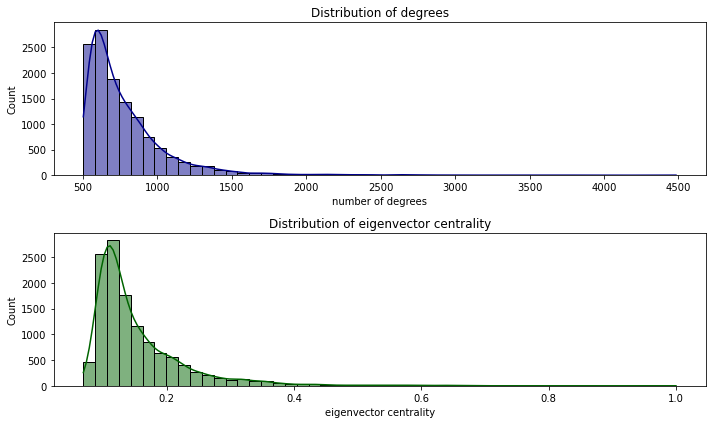

In [42]:
# plot degree and eigenvector centrality distributions
fig, axs = plt.subplots(2,1, tight_layout=True, figsize=(10,6))

sns.histplot(degree, kde=True, bins=50, color = 'darkblue', ax=axs[0])
sns.histplot(eig_centr, kde=True, bins=50, color = 'darkgreen', ax=axs[1])

axs[0].set(title='Distribution of degrees', xlabel='number of degrees')
axs[1].set(title='Distribution of eigenvector centrality', xlabel='eigenvector centrality')

plt.show()

In [43]:
print(f' The skill with the most adjacent edges to it is: {G.vs.select(_degree = G.maxdegree())["name"]}')

 The skill with the most adjacent edges to it is: ['manage staff']


The distributions of the vertex degrees and eigenvector centrality scores are both positively skewed. This shows there is a subset of skills that are relatively more central and connected to a larger group of other skills. These are likely to be more translational skills, but they might function as a connection between more specialized skill clusters.

### Community detection

To start detecting clusters within the network, I first compared three different types of community detection algorithms: Louvain algorithm, Leiden algorithm, and Infomap algorithm. Additionally, I compared different partition solutions, depending on what is used as edge weights: co-occurrence frequency, cosine similarity, or the sum of those. 

The Louvain community detection algorithm is a very popular algorithm for uncovering community structure. It is a modularity optimizing algorithm, which tries to maximize the difference between the actual number of edges in a community and the expected number of edges in the community. There has been some critique on the Louvain algorithm in that is may yield badly connected communities. To address that problem a new algorithm was introduced, very similar to the Louvain algorithm: the Leiden algorithm. Research has shown that this algorithm yields better connected communities, and when applied iteratively it converges to a partition in which all subsets of all communities are locally optimally assigned. Finally, I compared these to the Infomap algorithm. The algorithm uses the probability flow of random walks on a network as a proxy for information flows in the real system and it decomposes the network into modules by compressing a description of the probability flow.

I used the modularity score to evaluate the solution of the community detection algorithms. This is an often used quality metric for resulting partitions produced by different community detection alogrithms, which compares the number of links within and between communities. Higher values reflect better quality of partitions. Additionally, I compared different community partition solutions to assess their similarity, using Normalized Mutual Information. Higher values means greater resemblance between partition solutions. 

Note: For now I have tested algorithms that detect 'crisp' communities where each node belongs to only one community. This could help users of a taxonomy to have an intuitive understanding of the different clusters and which skills belong to those clusters (also for visualization). However, it is not unlikely that certain skills are linked to other clusters, especially in deeper layers of the taxonomy. An idea for the future would be to test fuzzy community detection algorithms where vertices (skills) could be assigned to more than one community with different degrees of likelihood (e.g. for the most fine-grained layer of the taxonomy).

#### Louvain algorithm

In [44]:
# using co-occurrence frequency as edge weights
random.seed(42)
louv_freq_coms_lay1 = G.community_multilevel(weights='co_occur_freq')
louv_freq_mod_lay1 = G.modularity(louv_freq_coms_lay1, weights='co_occur_freq')

In [45]:
print(f'{len(louv_freq_coms_lay1)} clusters were detected, with the following sizes:{louv_freq_coms_lay1.sizes()}')

12 clusters were detected, with the following sizes:[1386, 853, 1424, 1743, 689, 1017, 1832, 996, 811, 985, 254, 582]


In [46]:
# using cosine similarity as edge weights
random.seed(42)
louv_cs_coms_lay1 = G.community_multilevel(weights='cos_sim')
louv_cs_mod_lay1 = G.modularity(louv_cs_coms_lay1, weights='cos_sim')

In [47]:
print(f'{len(louv_cs_coms_lay1)} clusters were detected, with the following sizes:{louv_cs_coms_lay1.sizes()}')

9 clusters were detected, with the following sizes:[3523, 3002, 1295, 1468, 273, 1283, 636, 1091, 1]


In [50]:
# using the sum score as edge weights
random.seed(42)
louv_sum_coms_lay1 = G.community_multilevel(weights='sum_weight')
louv_sum_mod_lay1 = G.modularity(louv_cs_coms_lay1, weights='sum_weight')

In [51]:
print(f'{len(louv_sum_coms_lay1)} clusters were detected, with the following sizes:{louv_sum_coms_lay1.sizes()}')

12 clusters were detected, with the following sizes:[1416, 850, 1465, 1712, 1021, 1093, 1858, 845, 523, 980, 238, 571]


In [52]:
# compare modularity scores across the different Louvain partitions
print(f'modularity for partition with co-occurence as edge weights: {louv_freq_mod_lay1}')
print(f'modularity for partition with cosine similarity as edge weights: {louv_cs_mod_lay1}')
print(f'modularity for partition with sum weight as edge weights: {louv_sum_mod_lay1}')

modularity for partition with co-occurence as edge weights: 0.5588282709358402
modularity for partition with cosine similarity as edge weights: 0.27485298951044973
modularity for partition with sum weight as edge weights: 0.20163943636109516


In [55]:
# check resemblance between Louvain community detection solutions
louv_nmi1 = compare_communities(louv_freq_coms_lay1, louv_cs_coms_lay1, method="nmi")
louv_nmi2 = compare_communities(louv_freq_coms_lay1, louv_sum_coms_lay1, method="nmi")
louv_nmi3 = compare_communities(louv_cs_coms_lay1, louv_sum_coms_lay1, method="nmi")
print(f'NMI comparing co-occurence frequency vs. cosine similarity as edge weights: {louv_nmi1}')
print(f'NMI comparing co-occurence frequency vs. summed score as edge weights: {louv_nmi2}')
print(f'NMI comparing cosine similarity vs. summed score as edge weights: {louv_nmi3}')

NMI comparing co-occurence frequency vs. cosine similarity as edge weights: 0.20837800209204854
NMI comparing co-occurence frequency vs. summed score as edge weights: 0.907368445810626
NMI comparing cosine similarity vs. summed score as edge weights: 0.21401344645307696


In [54]:
# check clusters for solution with co-occurence frequency as edge weights
print(louv_freq_coms_lay1)

Clustering with 12572 elements and 12 clusters
[ 0] undertake continuous professional development in social work,
     psychological effects of war, deal with emergency care situations,
     kinesitherapy, assess offenders' risk behaviour, perform toxicological
     studies, evidence-based radiography practice, female reproductive system
     pathology, community education, integrate exercise science to the design
     of the programme, instruct on the use of hearing aids, types of
     aromatherapy treatments, person centred care, otorhinolaryngology, health
     care occupation-specific ethics, yoga, treat tooth decay, deliver group
     sessions on nutrition, respiratory medicine, blood type classification,
     pedagogy, manage operations in healthcare institutions, meet the
     requirements of social security reimbursement bodies, make clinical
     decisions, food labels, mechanotherapy, communicate by use of
     interpretation in social services, train medical staff on nutriti

#### Leiden algorithm

In [56]:
# using co-occurrence frequency as edge weights
"""
Using a negative number for iterations means that it will run iterations until a stable iteration is encountered.
That is, the quality was not increased during that iteration.
"""
random.seed(42)
leid_freq_coms_lay1 = G.community_leiden(objective_function="modularity", weights='co_occur_freq',
                                      n_iterations=-1)
leid_freq_mod_lay1 = G.modularity(leid_freq_coms_lay1, weights='co_occur_freq')

In [57]:
print(f'{len(leid_freq_coms_lay1)} clusters were detected, with the following sizes:{leid_freq_coms_lay1.sizes()}')

12 clusters were detected, with the following sizes:[1376, 669, 1586, 1726, 994, 1153, 1804, 971, 487, 982, 250, 574]


In [58]:
# using cosine similarity as edge weights
random.seed(42)
leid_cs_coms_lay1 = G.community_leiden(objective_function="modularity", weights='cos_sim',
                                      n_iterations=-1)
leid_cs_mod_lay1 = G.modularity(leid_cs_coms_lay1, weights='cos_sim')

In [59]:
print(f'{len(leid_cs_coms_lay1)} clusters were detected, with the following sizes:{leid_cs_coms_lay1.sizes()}')

8 clusters were detected, with the following sizes:[1800, 2879, 3355, 1746, 875, 268, 1648, 1]


In [60]:
# using the sum score as edge weights
random.seed(42)
leid_sum_coms_lay1 = G.community_leiden(objective_function="modularity", weights='sum_weight',
                                      n_iterations=-1)
leid_sum_mod_lay1 = G.modularity(leid_sum_coms_lay1, weights='sum_weight')

In [61]:
print(f'{len(leid_sum_coms_lay1)} clusters were detected, with the following sizes:{leid_sum_coms_lay1.sizes()}')

11 clusters were detected, with the following sizes:[1387, 2138, 1329, 1661, 1081, 1851, 841, 488, 982, 244, 570]


In [62]:
# compare modularity scores across the different Leiden partitions
print(f'modularity for partition with co-occurence as edge weights: {leid_freq_mod_lay1}')
print(f'modularity for partition with cosine similarity as edge weights: {leid_cs_mod_lay1}')
print(f'modularity for partition with sum weight as edge weights: {leid_sum_mod_lay1}')

modularity for partition with co-occurence as edge weights: 0.5614294310535051
modularity for partition with cosine similarity as edge weights: 0.2750968489998956
modularity for partition with sum weight as edge weights: 0.5334623571486846


In [63]:
# check resemblance between Louvain community detection solutions
leid_nmi1 = compare_communities(leid_freq_coms_lay1, leid_cs_coms_lay1, method="nmi")
leid_nmi2 = compare_communities(leid_freq_coms_lay1, leid_sum_coms_lay1, method="nmi")
leid_nmi3 = compare_communities(leid_cs_coms_lay1, leid_sum_coms_lay1, method="nmi")
print(f'NMI comparing co-occurence frequency vs. cosine similarity as edge weights: {leid_nmi1}')
print(f'NMI comparing co-occurence frequency vs. summed score as edge weights: {leid_nmi2}')
print(f'NMI comparing cosine similarity vs. summed score as edge weights: {leid_nmi3}')

NMI comparing co-occurence frequency vs. cosine similarity as edge weights: 0.20511070060630432
NMI comparing co-occurence frequency vs. summed score as edge weights: 0.8676222639020976
NMI comparing cosine similarity vs. summed score as edge weights: 0.20394533967181036


In [65]:
# check clusters for solution with co-occurence frequency as edge weights
print(leid_freq_coms_lay1)

Clustering with 12572 elements and 12 clusters
[ 0] undertake continuous professional development in social work,
     psychological effects of war, deal with emergency care situations,
     kinesitherapy, assess offenders' risk behaviour, perform toxicological
     studies, evidence-based radiography practice, female reproductive system
     pathology, community education, integrate exercise science to the design
     of the programme, instruct on the use of hearing aids, types of
     aromatherapy treatments, person centred care, otorhinolaryngology, health
     care occupation-specific ethics, yoga, treat tooth decay, deliver group
     sessions on nutrition, respiratory medicine, blood type classification,
     pedagogy, manage operations in healthcare institutions, meet the
     requirements of social security reimbursement bodies, make clinical
     decisions, food labels, mechanotherapy, communicate by use of
     interpretation in social services, train medical staff on nutriti

#### Infomap algorithm

In [66]:
# using co-occurence frequency as edge weights
random.seed(42)
infomap_freq_coms_lay1 = G.community_infomap(edge_weights='co_occur_freq',trials=10)
infomap_freq_mod_lay1 = G.modularity(infomap_freq_coms_lay1, weights='co_occur_freq')

In [67]:
print(f'{len(infomap_freq_coms_lay1)} clusters were detected, with the following sizes:{infomap_freq_coms_lay1.sizes()}')

106 clusters were detected, with the following sizes:[225, 635, 3, 42, 1441, 73, 90, 283, 987, 26, 163, 363, 1054, 215, 134, 461, 19, 137, 298, 37, 91, 532, 366, 415, 834, 171, 12, 16, 245, 20, 103, 109, 115, 107, 312, 6, 301, 29, 81, 31, 98, 16, 13, 110, 41, 92, 48, 224, 16, 28, 15, 21, 117, 6, 68, 95, 64, 19, 69, 103, 14, 21, 14, 24, 7, 19, 78, 16, 11, 5, 9, 11, 5, 16, 19, 4, 10, 20, 34, 16, 55, 28, 11, 16, 29, 23, 14, 6, 7, 17, 11, 16, 12, 16, 10, 20, 8, 6, 11, 11, 10, 8, 9, 8, 4, 8]


In [68]:
# using cosine similarity as edge weights
random.seed(42)
infomap_cs_coms_lay1 = G.community_infomap(edge_weights='cos_sim',trials=10)
infomap_cs_mod_lay1 = G.modularity(infomap_cs_coms_lay1, weights='cos_sim')

In [69]:
print(f'{len(infomap_cs_coms_lay1)} clusters were detected, with the following sizes:{infomap_cs_coms_lay1.sizes()}')

4 clusters were detected, with the following sizes:[12482, 52, 37, 1]


In [70]:
# using the sum score as edge weights
random.seed(42)
infomap_sum_coms_lay1 = G.community_infomap(edge_weights='sum_weight',trials=10)
infomap_sum_mod_lay1 = G.modularity(infomap_sum_coms_lay1, weights='sum_weight')

In [71]:
print(f'{len(infomap_sum_coms_lay1)} clusters were detected, with the following sizes:{infomap_sum_coms_lay1.sizes()}')

88 clusters were detected, with the following sizes:[235, 635, 1043, 42, 1520, 72, 88, 288, 24, 152, 358, 1112, 219, 8, 459, 19, 137, 315, 30, 95, 528, 364, 413, 967, 186, 16, 320, 20, 88, 105, 116, 125, 307, 6, 298, 22, 81, 29, 99, 13, 113, 100, 47, 244, 16, 73, 28, 37, 15, 21, 114, 5, 100, 64, 19, 74, 91, 14, 19, 14, 24, 7, 78, 11, 9, 5, 16, 4, 8, 21, 26, 15, 22, 21, 11, 16, 16, 20, 8, 11, 7, 11, 9, 6, 10, 8, 9, 1]


In [72]:
# compare modularity scores across the different Infomap partitions
print(f'modularity for partition with co-occurence as edge weights: {infomap_freq_mod_lay1}')
print(f'modularity for partition with cosine similarity as edge weights: {infomap_cs_mod_lay1}')
print(f'modularity for partition with sum weight as edge weights: {infomap_sum_mod_lay1}')

modularity for partition with co-occurence as edge weights: 0.5298621127926911
modularity for partition with cosine similarity as edge weights: 0.015368247982022739
modularity for partition with sum weight as edge weights: 0.5059956352336239


In [73]:
# check resemblance between Louvain community detection solutions
info_nmi1 = compare_communities(infomap_freq_coms_lay1, infomap_cs_coms_lay1, method="nmi")
info_nmi2 = compare_communities(infomap_freq_coms_lay1, infomap_sum_coms_lay1, method="nmi")
info_nmi3 = compare_communities(infomap_cs_coms_lay1, infomap_sum_coms_lay1, method="nmi")
print(f'NMI comparing co-occurence frequency vs. cosine similarity as edge weights: {info_nmi1}')
print(f'NMI comparing co-occurence frequency vs. summed score as edge weights: {info_nmi2}')
print(f'NMI comparing cosine similarity vs. summed score as edge weights: {info_nmi3}')

NMI comparing co-occurence frequency vs. cosine similarity as edge weights: 0.015078452172098402
NMI comparing co-occurence frequency vs. summed score as edge weights: 0.9376399444940816
NMI comparing cosine similarity vs. summed score as edge weights: 0.010722253374694186


In [74]:
# check clusters for solution with co-occurence frequency as edge weights
print(infomap_freq_coms_lay1)

Clustering with 12572 elements and 106 clusters
[  0] undertake continuous professional development in social work,
      psychological effects of war, assess offenders' risk behaviour,
      community education, communicate by use of interpretation in social
      services, provide information on school services, inform on the risks of
      substance and alcohol abuse, use person-centred planning, child
      protection, assess clients' drug and alcohol addictions, assess the
      development of youth, assess social work students, apply change
      management, provide testimony in court hearings, support the
      positiveness of youths, support children's wellbeing, meet standards of
      practice in social services, advise on conflict management, empower
      individuals, families and groups, support volunteers, delegate
      activities, educate on emergency management, conduct cleaning tasks,
      evaluate staff performance in social work, contribute to the
      safeguardin

#### Layer 1 of skills taxonomy

Based on the modularity values plotted below it seems that the partition solutions with the use of co-occurrence frequency or summed scores as edge weights have similar quality, except when using the Louvain algorithm with summed score as edge weights. The Normalized Mutual Information (NMI) score is fairly high across all partition solutions, indicating similar clustering structures between algorithms. Especially the clustering based on Louvain and Leiden algorithms are similar, likely because both are based on modularity optimization. Since Infomap tends to detect more smaller clusters, which is not optimal for the higher layers of the taxonomy, and the Leiden algorithm is considered to yield better connected communities than the Louvain algorith (and had highest modularity scores), I decided to use the Leiden algorithm to create the next layers of the taxonomy. 

The quality of partitioning (based on modularity) with the Leiden algorithm is very similar when using only co-occurrence frequency as edge weights or the summed measure. To keep all information about possible connections between the skills, I decided to use the summed measure as edge weights. Because of the scaling, the co-occurence frequency will have the biggest influence. For this data this may actually be preferred as that measure captures best which skills are together considered necessary for different occupations, and could thus be informative for a skills taxonomy geared towards users in the labour market. For skills that were not mentioned together under occupations (frequency = 0), the cosine similarity can still provide some information about similarity between those skills. 

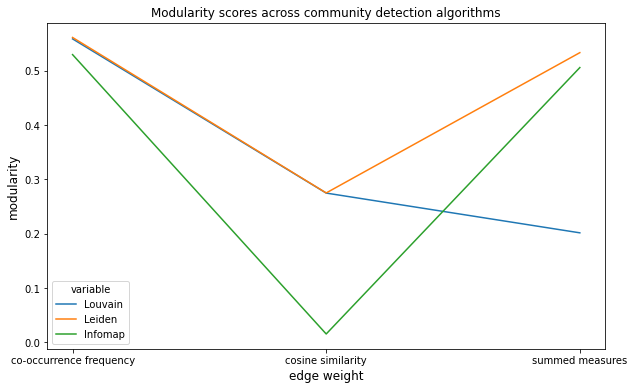

In [75]:
# plot modularity scores for the three different algorithms

x=['co-occurrence frequency','cosine similarity', 'summed measures']
y_louv=[louv_freq_mod_lay1, louv_cs_mod_lay1, louv_sum_mod_lay1]
y_leid=[leid_freq_mod_lay1, leid_cs_mod_lay1, leid_sum_mod_lay1]
y_info=[infomap_freq_mod_lay1, infomap_cs_mod_lay1, infomap_sum_mod_lay1]

modul_data = pd.DataFrame({'edge weight': x, 'Louvain': y_louv, 'Leiden': y_leid, 'Infomap': y_info})

plt.figure(figsize=(10,6))
sns.lineplot(x='edge weight', y='value', hue='variable', data=pd.melt(modul_data, ['edge weight']))
plt.title('Modularity scores across community detection algorithms')
plt.xlabel("edge weight", fontsize='large')
plt.ylabel("modularity", fontsize='large')
plt.show()

In [76]:
# comparing resemblance detected communities across the three different algorithms
nmi_louv_leid = compare_communities(louv_freq_coms_lay1, leid_freq_coms_lay1, method="nmi")
nmi_louv_info = compare_communities(louv_freq_coms_lay1, infomap_freq_coms_lay1, method="nmi")
nmi_leid_info = compare_communities(leid_freq_coms_lay1, infomap_freq_coms_lay1, method="nmi")

nmi_louv_leid2 = compare_communities(louv_sum_coms_lay1, leid_sum_coms_lay1, method="nmi")
nmi_louv_info2 = compare_communities(louv_sum_coms_lay1, infomap_freq_coms_lay1, method="nmi")
nmi_leid_info2 = compare_communities(leid_sum_coms_lay1, infomap_freq_coms_lay1, method="nmi")

print(f'NMI comparing Louvain vs. Leiden with co-occurrence frequency as edge weights: {nmi_louv_leid}')
print(f'NMI comparing Louvain vs. Infomap with co-occurrence frequency as edge weights: {nmi_louv_info}')
print(f'NMI comparing Leiden vs. Infomap with co-occurrence frequency as edge weights: {nmi_leid_info}')
print(f'NMI comparing Louvain vs. Leiden with summed measure as edge weights: {nmi_louv_leid2}')
print(f'NMI comparing Louvain vs. Infomap with summed measure as edge weights: {nmi_louv_info2}')
print(f'NMI comparing Leiden vs. Infomap with summed measure as edge weights: {nmi_leid_info2}')

NMI comparing Louvain vs. Leiden with co-occurrence frequency as edge weights: 0.8797667286683888
NMI comparing Louvain vs. Infomap with co-occurrence frequency as edge weights: 0.7147563379786946
NMI comparing Leiden vs. Infomap with co-occurrence frequency as edge weights: 0.71876280716412
NMI comparing Louvain vs. Leiden with summed measure as edge weights: 0.895796167108313
NMI comparing Louvain vs. Infomap with summed measure as edge weights: 0.7069637564248978
NMI comparing Leiden vs. Infomap with summed measure as edge weights: 0.6870090637509177


In [77]:
# get cluster allocation of skills for layer 1 of taxonomy
lay1_c_list = pd.Series(leid_sum_coms_lay1.membership)
lay1_skills = pd.Series(G.vs["name"])

layer1_df=pd.concat([lay1_skills, lay1_c_list], axis=1)
layer1_df.rename(columns={0:"skill_label", 1:"c_layer1"}, inplace=True)
layer1_df.head(10)

,skill_label,c_layer1
0,undertake continuous professional development ...,0
1,monitor temperature in farinaceous processes,1
2,report on voting process,2
3,facilitate access to information,2
4,operate pumps,3
5,cooperate in linguistic process steps,4
6,oversee warehouse value-added activities,1
7,psychological effects of war,0
8,stand watch on vessel,1
9,maintain statutory books,2


#### Layer 2 of skills taxonomy

Not all output objects from iGraph are iterable, so layer 2 objects need to be created via if/elif statements and stored in seperate lists, so these can be used to create layer 3 of the skills taxonomy.

In [78]:
# check nr of clusters detected in layer 1: needed for code below
len(leid_sum_coms_lay1)

11

In [79]:
random.seed(42)

for i in range(len(leid_sum_coms_lay1)):
    
    if i == 0:
        G2_0 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_0 = G2_0.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=-1)
        leid_sum_mod_lay2_0 = G2_0.modularity(leid_sum_coms_lay2_0, weights='sum_weight')
    elif i == 1:
        G2_1 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_1 = G2_1.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=-1)
        leid_sum_mod_lay2_1 = G2_1.modularity(leid_sum_coms_lay2_1, weights='sum_weight')
    elif i == 2:
        G2_2 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_2 = G2_2.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=-1)
        leid_sum_mod_lay2_2 = G2_2.modularity(leid_sum_coms_lay2_2, weights='sum_weight')
    elif i == 3:
        G2_3 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_3 = G2_3.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=-1)
        leid_sum_mod_lay2_3 = G2_3.modularity(leid_sum_coms_lay2_3, weights='sum_weight')
    elif i == 4:
        G2_4 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_4 = G2_4.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=-1)
        leid_sum_mod_lay2_4 = G2_4.modularity(leid_sum_coms_lay2_4, weights='sum_weight')
    elif i == 5:
        G2_5 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_5 = G2_5.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=-1)
        leid_sum_mod_lay2_5 = G2_5.modularity(leid_sum_coms_lay2_5, weights='sum_weight')
    elif i == 6:
        G2_6 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_6 = G2_6.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=-1)
        leid_sum_mod_lay2_6 = G2_6.modularity(leid_sum_coms_lay2_6, weights='sum_weight')
    elif i == 7:
        G2_7 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_7 = G2_7.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=-1)
        leid_sum_mod_lay2_7 = G2_7.modularity(leid_sum_coms_lay2_7, weights='sum_weight')
    elif i == 8:
        G2_8 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_8 = G2_8.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=-1)
        leid_sum_mod_lay2_8 = G2_8.modularity(leid_sum_coms_lay2_8, weights='sum_weight')
    elif i == 9:
        G2_9 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_9 = G2_9.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=-1)
        leid_sum_mod_lay2_9 = G2_9.modularity(leid_sum_coms_lay2_9, weights='sum_weight')
    elif i == 10:
        G2_10 = leid_sum_coms_lay1.subgraph(i)
        leid_sum_coms_lay2_10 = G2_10.community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=-1)
        leid_sum_mod_lay2_10 = G2_10.modularity(leid_sum_coms_lay2_10, weights='sum_weight')

In [80]:
# check nested cluster structure and modularity
print(f'{len(leid_sum_coms_lay2_0)} clusters were detected nested under cluster 0 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_0.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_0}.\n')    
print(f'{len(leid_sum_coms_lay2_1)} clusters were detected nested under cluster 1 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_1.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_1}.\n')  
print(f'{len(leid_sum_coms_lay2_2)} clusters were detected nested under cluster 2 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_2.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_2}.\n')    
print(f'{len(leid_sum_coms_lay2_3)} clusters were detected nested under cluster 3 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_3.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_3}.\n')    
print(f'{len(leid_sum_coms_lay2_4)} clusters were detected nested under cluster 4 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_4.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_4}.\n')    
print(f'{len(leid_sum_coms_lay2_5)} clusters were detected nested under cluster 5 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_5.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_5}.\n')    
print(f'{len(leid_sum_coms_lay2_6)} clusters were detected nested under cluster 6 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_6.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_6}.\n')    
print(f'{len(leid_sum_coms_lay2_7)} clusters were detected nested under cluster 7 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_7.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_7}.\n')    
print(f'{len(leid_sum_coms_lay2_8)} clusters were detected nested under cluster 8 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_8.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_8}.\n')    
print(f'{len(leid_sum_coms_lay2_9)} clusters were detected nested under cluster 9 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_9.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_9}.\n')    
print(f'{len(leid_sum_coms_lay2_10)} clusters were detected nested under cluster 10 from layer 1.\nThese nested clusters have the following sizes: {leid_sum_coms_lay2_10.sizes()}.\nModularity for this partition: {leid_sum_mod_lay2_10}.\n')    

4 clusters were detected nested under cluster 0 from layer 1.
These nested clusters have the following sizes: [210, 947, 24, 206].
Modularity for this partition: 0.3964286724621307.

9 clusters were detected nested under cluster 1 from layer 1.
These nested clusters have the following sizes: [510, 372, 292, 314, 144, 241, 14, 231, 20].
Modularity for this partition: 0.5256938697203578.

5 clusters were detected nested under cluster 2 from layer 1.
These nested clusters have the following sizes: [253, 262, 163, 331, 320].
Modularity for this partition: 0.3138135505212226.

6 clusters were detected nested under cluster 3 from layer 1.
These nested clusters have the following sizes: [307, 269, 148, 202, 255, 480].
Modularity for this partition: 0.30388881776505017.

8 clusters were detected nested under cluster 4 from layer 1.
These nested clusters have the following sizes: [72, 218, 173, 226, 100, 138, 146, 8].
Modularity for this partition: 0.5046905958031697.

5 clusters were detected 

In [81]:
# get cluster allocation of skills for layer 2 of taxonomy
lay2_c_list0 = pd.Series(leid_sum_coms_lay2_0.membership)
lay2_skills0 = pd.Series(G2_0.vs["name"])
lay2_c_list1 = pd.Series(leid_sum_coms_lay2_1.membership)
lay2_skills1 = pd.Series(G2_1.vs["name"])
lay2_c_list2 = pd.Series(leid_sum_coms_lay2_2.membership)
lay2_skills2 = pd.Series(G2_2.vs["name"])
lay2_c_list3 = pd.Series(leid_sum_coms_lay2_3.membership)
lay2_skills3 = pd.Series(G2_3.vs["name"])
lay2_c_list4 = pd.Series(leid_sum_coms_lay2_4.membership)
lay2_skills4 = pd.Series(G2_4.vs["name"])
lay2_c_list5 = pd.Series(leid_sum_coms_lay2_5.membership)
lay2_skills5 = pd.Series(G2_5.vs["name"])
lay2_c_list6 = pd.Series(leid_sum_coms_lay2_6.membership)
lay2_skills6 = pd.Series(G2_6.vs["name"])
lay2_c_list7 = pd.Series(leid_sum_coms_lay2_7.membership)
lay2_skills7 = pd.Series(G2_7.vs["name"])
lay2_c_list8 = pd.Series(leid_sum_coms_lay2_8.membership)
lay2_skills8 = pd.Series(G2_8.vs["name"])
lay2_c_list9 = pd.Series(leid_sum_coms_lay2_9.membership)
lay2_skills9 = pd.Series(G2_9.vs["name"])
lay2_c_list10 = pd.Series(leid_sum_coms_lay2_10.membership)
lay2_skills10 = pd.Series(G2_10.vs["name"])

temp_df0=pd.concat([lay2_skills0, lay2_c_list0], axis=1)
temp_df1=pd.concat([lay2_skills1, lay2_c_list1], axis=1)
temp_df2=pd.concat([lay2_skills2, lay2_c_list2], axis=1)
temp_df3=pd.concat([lay2_skills3, lay2_c_list3], axis=1)
temp_df4=pd.concat([lay2_skills4, lay2_c_list4], axis=1)
temp_df5=pd.concat([lay2_skills5, lay2_c_list5], axis=1)
temp_df6=pd.concat([lay2_skills6, lay2_c_list6], axis=1)
temp_df7=pd.concat([lay2_skills7, lay2_c_list7], axis=1)
temp_df8=pd.concat([lay2_skills8, lay2_c_list8], axis=1)
temp_df9=pd.concat([lay2_skills9, lay2_c_list9], axis=1)
temp_df10=pd.concat([lay2_skills10, lay2_c_list10], axis=1)

dflist =[temp_df0, temp_df1, temp_df2, temp_df3, temp_df4, temp_df5, 
         temp_df6, temp_df7, temp_df8, temp_df9, temp_df10]

layer2_df = pd.concat(dflist)
layer2_df.rename(columns={0:"skill_label", 1:"c_layer2"}, inplace=True)

# double check no skills are allocated to two clusters
print(f'layer2_df has {layer2_df.skill_label.nunique()} unique skills listed. This should be 12572.')
layer2_df.head()

layer2_df has 12572 unique skills listed. This should be 12572.


,skill_label,c_layer2
0,undertake continuous professional development ...,0
1,psychological effects of war,0
2,deal with emergency care situations,1
3,kinesitherapy,1
4,assess offenders' risk behaviour,0


In [82]:
# create taxonomy data frame
taxonomy_df = pd.merge(layer1_df, layer2_df, how='left', on='skill_label')
print(taxonomy_df.shape)
taxonomy_df.head(10)

(12572, 3)


,skill_label,c_layer1,c_layer2
0,undertake continuous professional development ...,0,0
1,monitor temperature in farinaceous processes,1,0
2,report on voting process,2,0
3,facilitate access to information,2,1
4,operate pumps,3,0
5,cooperate in linguistic process steps,4,0
6,oversee warehouse value-added activities,1,1
7,psychological effects of war,0,0
8,stand watch on vessel,1,2
9,maintain statutory books,2,1


#### Layer 3 of skills taxonomy

In [89]:
# create layer 3, nested under all clusters from layer 2, which are in turn nested under cluster 0 from layer 1
random.seed(42)
leid_sum_coms_lay3_lay2_lay1c0 = []
leid_sum_mod_lay3_lay2_lay1c0 = []

G3_G2_Gc0 = leid_sum_coms_lay2_0.subgraphs()

for i in range(len(G3_G2_Gc0)):
    coms = G3_G2_Gc0[i].community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=-1)
    leid_sum_coms_lay3_lay2_lay1c0.append(coms)
    
    mod = G3_G2_Gc0[i].modularity(coms, weights='sum_weight')
    leid_sum_mod_lay3_lay2_lay1c0.append(mod)

In [90]:
# check nested cluster structure and modularity
for i in range(len(G3_G2_Gc0)):
    print(f'{len(leid_sum_coms_lay3_lay2_lay1c0[i])} clusters were detected nested under layer1-cluster0 --> layer2-cluster{i}.\
    \nThese nested clusters have the following sizes: {leid_sum_coms_lay3_lay2_lay1c0[i].sizes()}.\
    \nModularity for this partition: {leid_sum_mod_lay3_lay2_lay1c0[i]}.\n')

4 clusters were detected nested under layer1-cluster0 --> layer2-cluster0.    
These nested clusters have the following sizes: [58, 93, 26, 33].    
Modularity for this partition: 0.06984369824410933.

9 clusters were detected nested under layer1-cluster0 --> layer2-cluster1.    
These nested clusters have the following sizes: [230, 111, 184, 58, 92, 46, 82, 38, 106].    
Modularity for this partition: 0.2683502396516724.

3 clusters were detected nested under layer1-cluster0 --> layer2-cluster2.    
These nested clusters have the following sizes: [9, 7, 8].    
Modularity for this partition: 0.17083753387401446.

3 clusters were detected nested under layer1-cluster0 --> layer2-cluster3.    
These nested clusters have the following sizes: [74, 97, 35].    
Modularity for this partition: 0.3668083105054627.



In [91]:
# get cluster allocation of skills for layer 3 of taxonomy nested under cluster 0 from layer 1
layer3_lay1c0_df = pd.DataFrame(columns=["skill_label", "c_layer3"])
for i in range(len(G3_G2_Gc0)):
    lay3_c_list = pd.Series(leid_sum_coms_lay3_lay2_lay1c0[i].membership)
    lay3_skills = pd.Series(G3_G2_Gc0[i].vs["name"])
    
    temp_df=pd.concat([lay3_skills, lay3_c_list], axis=1)
    temp_df.rename(columns={0:"skill_label", 1:"c_layer3"}, inplace=True)
    
    layer3_lay1c0_df = layer3_lay1c0_df.append(temp_df)
    
print(f'length of datafile should be {leid_sum_coms_lay1.sizes()[0]} and is {len(layer3_lay1c0_df)}')

length of datafile should be 1387 and is 1387


In [92]:
# create layer 3, nested under all clusters from layer 2, which are in turn nested under cluster 1 from layer 1
random.seed(42)
leid_sum_coms_lay3_lay2_lay1c1 = []
leid_sum_mod_lay3_lay2_lay1c1 = []

G3_G2_Gc1 = leid_sum_coms_lay2_1.subgraphs()

for i in range(len(G3_G2_Gc1)):
    coms = G3_G2_Gc1[i].community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=-1)
    leid_sum_coms_lay3_lay2_lay1c1.append(coms)
    
    mod = G3_G2_Gc1[i].modularity(coms, weights='sum_weight')
    leid_sum_mod_lay3_lay2_lay1c1.append(mod)

In [93]:
# check nested cluster structure and modularity
for i in range(len(G3_G2_Gc1)):
    print(f'{len(leid_sum_coms_lay3_lay2_lay1c1[i])} clusters were detected nested under layer1-cluster1 --> layer2-cluster{i}.\
    \nThese nested clusters have the following sizes: {leid_sum_coms_lay3_lay2_lay1c1[i].sizes()}.\
    \nModularity for this partition: {leid_sum_mod_lay3_lay2_lay1c1[i]}.\n')

5 clusters were detected nested under layer1-cluster1 --> layer2-cluster0.    
These nested clusters have the following sizes: [80, 146, 48, 159, 77].    
Modularity for this partition: 0.21078893542268326.

8 clusters were detected nested under layer1-cluster1 --> layer2-cluster1.    
These nested clusters have the following sizes: [80, 70, 47, 39, 94, 30, 5, 7].    
Modularity for this partition: 0.4704963758643746.

3 clusters were detected nested under layer1-cluster1 --> layer2-cluster2.    
These nested clusters have the following sizes: [83, 115, 94].    
Modularity for this partition: 0.33579057887778474.

4 clusters were detected nested under layer1-cluster1 --> layer2-cluster3.    
These nested clusters have the following sizes: [114, 88, 58, 54].    
Modularity for this partition: 0.43929952882450746.

6 clusters were detected nested under layer1-cluster1 --> layer2-cluster4.    
These nested clusters have the following sizes: [12, 19, 30, 32, 21, 30].    
Modularity for thi

In [94]:
# get cluster allocation of skills for layer 3 of taxonomy nested under cluster 1 from layer 1
layer3_lay1c1_df = pd.DataFrame(columns=["skill_label", "c_layer3"])
for i in range(len(G3_G2_Gc1)):
    lay3_c_list = pd.Series(leid_sum_coms_lay3_lay2_lay1c1[i].membership)
    lay3_skills = pd.Series(G3_G2_Gc1[i].vs["name"])
    
    temp_df=pd.concat([lay3_skills, lay3_c_list], axis=1)
    temp_df.rename(columns={0:"skill_label", 1:"c_layer3"}, inplace=True)
    
    layer3_lay1c1_df = layer3_lay1c1_df.append(temp_df)
    
print(f'length of datafile should be {leid_sum_coms_lay1.sizes()[1]} and is {len(layer3_lay1c1_df)}')

length of datafile should be 2138 and is 2138


In [95]:
# create layer 3, nested under all clusters from layer 2, which are in turn nested under cluster 2 from layer 1
random.seed(42)
leid_sum_coms_lay3_lay2_lay1c2 = []
leid_sum_mod_lay3_lay2_lay1c2 = []

G3_G2_Gc2 = leid_sum_coms_lay2_2.subgraphs()

for i in range(len(G3_G2_Gc2)):
    coms = G3_G2_Gc2[i].community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=-1)
    leid_sum_coms_lay3_lay2_lay1c2.append(coms)
    
    mod = G3_G2_Gc2[i].modularity(coms, weights='sum_weight')
    leid_sum_mod_lay3_lay2_lay1c2.append(mod)

In [96]:
# check nested cluster structure and modularity
for i in range(len(G3_G2_Gc2)):
    print(f'{len(leid_sum_coms_lay3_lay2_lay1c2[i])} clusters were detected nested under layer1-cluster2 --> layer2-cluster{i}.\
    \nThese nested clusters have the following sizes: {leid_sum_coms_lay3_lay2_lay1c2[i].sizes()}.\
    \nModularity for this partition: {leid_sum_mod_lay3_lay2_lay1c2[i]}.\n')

6 clusters were detected nested under layer1-cluster2 --> layer2-cluster0.    
These nested clusters have the following sizes: [27, 31, 44, 45, 54, 52].    
Modularity for this partition: 0.2954001707208639.

6 clusters were detected nested under layer1-cluster2 --> layer2-cluster1.    
These nested clusters have the following sizes: [47, 72, 106, 25, 4, 8].    
Modularity for this partition: 0.3687931471176251.

4 clusters were detected nested under layer1-cluster2 --> layer2-cluster2.    
These nested clusters have the following sizes: [37, 60, 38, 28].    
Modularity for this partition: 0.16383239640584618.

7 clusters were detected nested under layer1-cluster2 --> layer2-cluster3.    
These nested clusters have the following sizes: [78, 48, 66, 31, 54, 37, 17].    
Modularity for this partition: 0.2655490347272112.

4 clusters were detected nested under layer1-cluster2 --> layer2-cluster4.    
These nested clusters have the following sizes: [112, 78, 83, 47].    
Modularity for thi

In [97]:
# get cluster allocation of skills for layer 3 of taxonomy nested under cluster 2 from layer 1
layer3_lay1c2_df = pd.DataFrame(columns=["skill_label", "c_layer3"])
for i in range(len(G3_G2_Gc2)):
    lay3_c_list = pd.Series(leid_sum_coms_lay3_lay2_lay1c2[i].membership)
    lay3_skills = pd.Series(G3_G2_Gc2[i].vs["name"])
    
    temp_df=pd.concat([lay3_skills, lay3_c_list], axis=1)
    temp_df.rename(columns={0:"skill_label", 1:"c_layer3"}, inplace=True)
    
    layer3_lay1c2_df = layer3_lay1c2_df.append(temp_df)
    
print(f'length of datafile should be {leid_sum_coms_lay1.sizes()[2]} and is {len(layer3_lay1c2_df)}')

length of datafile should be 1329 and is 1329


In [98]:
# create layer 3, nested under all clusters from layer 2, which are in turn nested under cluster 3 from layer 1
random.seed(42)
leid_sum_coms_lay3_lay2_lay1c3 = []
leid_sum_mod_lay3_lay2_lay1c3 = []

G3_G2_Gc3 = leid_sum_coms_lay2_3.subgraphs()

for i in range(len(G3_G2_Gc3)):
    coms = G3_G2_Gc3[i].community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=-1)
    leid_sum_coms_lay3_lay2_lay1c3.append(coms)
    
    mod = G3_G2_Gc3[i].modularity(coms, weights='sum_weight')
    leid_sum_mod_lay3_lay2_lay1c3.append(mod)

In [99]:
# check nested cluster structure and modularity
for i in range(len(G3_G2_Gc3)):
    print(f'{len(leid_sum_coms_lay3_lay2_lay1c3[i])} clusters were detected nested under layer1-cluster3 --> layer2-cluster{i}.\
    \nThese nested clusters have the following sizes: {leid_sum_coms_lay3_lay2_lay1c3[i].sizes()}.\
    \nModularity for this partition: {leid_sum_mod_lay3_lay2_lay1c3[i]}.\n')

4 clusters were detected nested under layer1-cluster3 --> layer2-cluster0.    
These nested clusters have the following sizes: [104, 78, 61, 64].    
Modularity for this partition: 0.3260939047905699.

3 clusters were detected nested under layer1-cluster3 --> layer2-cluster1.    
These nested clusters have the following sizes: [152, 34, 83].    
Modularity for this partition: 0.25430447300433856.

3 clusters were detected nested under layer1-cluster3 --> layer2-cluster2.    
These nested clusters have the following sizes: [70, 41, 37].    
Modularity for this partition: 0.23080899872300342.

4 clusters were detected nested under layer1-cluster3 --> layer2-cluster3.    
These nested clusters have the following sizes: [38, 77, 61, 26].    
Modularity for this partition: 0.16636907066339865.

4 clusters were detected nested under layer1-cluster3 --> layer2-cluster4.    
These nested clusters have the following sizes: [71, 55, 81, 48].    
Modularity for this partition: 0.21677759281844602

In [100]:
# get cluster allocation of skills for layer 3 of taxonomy nested under cluster 3 from layer 1
layer3_lay1c3_df = pd.DataFrame(columns=["skill_label", "c_layer3"])
for i in range(len(G3_G2_Gc3)):
    lay3_c_list = pd.Series(leid_sum_coms_lay3_lay2_lay1c3[i].membership)
    lay3_skills = pd.Series(G3_G2_Gc3[i].vs["name"])
    
    temp_df=pd.concat([lay3_skills, lay3_c_list], axis=1)
    temp_df.rename(columns={0:"skill_label", 1:"c_layer3"}, inplace=True)
    
    layer3_lay1c3_df = layer3_lay1c3_df.append(temp_df)
    
print(f'length of datafile should be {leid_sum_coms_lay1.sizes()[3]} and is {len(layer3_lay1c3_df)}')

length of datafile should be 1661 and is 1661


In [101]:
# create layer 3, nested under all clusters from layer 2, which are in turn nested under cluster 4 from layer 1
random.seed(42)
leid_sum_coms_lay3_lay2_lay1c4 = []
leid_sum_mod_lay3_lay2_lay1c4 = []

G3_G2_Gc4 = leid_sum_coms_lay2_4.subgraphs()

for i in range(len(G3_G2_Gc4)):
    coms = G3_G2_Gc4[i].community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=-1)
    leid_sum_coms_lay3_lay2_lay1c4.append(coms)
    
    mod = G3_G2_Gc4[i].modularity(coms, weights='sum_weight')
    leid_sum_mod_lay3_lay2_lay1c4.append(mod)

In [102]:
# check nested cluster structure and modularity
for i in range(len(G3_G2_Gc4)):
    print(f'{len(leid_sum_coms_lay3_lay2_lay1c4[i])} clusters were detected nested under layer1-cluster4 --> layer2-cluster{i}.\
    \nThese nested clusters have the following sizes: {leid_sum_coms_lay3_lay2_lay1c4[i].sizes()}.\
    \nModularity for this partition: {leid_sum_mod_lay3_lay2_lay1c4[i]}.\n')

4 clusters were detected nested under layer1-cluster4 --> layer2-cluster0.    
These nested clusters have the following sizes: [34, 13, 22, 3].    
Modularity for this partition: 0.2032810356590715.

4 clusters were detected nested under layer1-cluster4 --> layer2-cluster1.    
These nested clusters have the following sizes: [50, 52, 95, 21].    
Modularity for this partition: 0.18173699873958768.

5 clusters were detected nested under layer1-cluster4 --> layer2-cluster2.    
These nested clusters have the following sizes: [63, 33, 46, 24, 7].    
Modularity for this partition: 0.39964256786700414.

5 clusters were detected nested under layer1-cluster4 --> layer2-cluster3.    
These nested clusters have the following sizes: [24, 49, 54, 52, 47].    
Modularity for this partition: 0.3067054000327513.

6 clusters were detected nested under layer1-cluster4 --> layer2-cluster4.    
These nested clusters have the following sizes: [15, 10, 20, 11, 20, 24].    
Modularity for this partition: 

In [103]:
# get cluster allocation of skills for layer 3 of taxonomy nested under cluster 4 from layer 1
layer3_lay1c4_df = pd.DataFrame(columns=["skill_label", "c_layer3"])
for i in range(len(G3_G2_Gc4)):
    lay3_c_list = pd.Series(leid_sum_coms_lay3_lay2_lay1c5[i].membership)
    lay3_skills = pd.Series(G3_G2_Gc4[i].vs["name"])
    
    temp_df=pd.concat([lay3_skills, lay3_c_list], axis=1)
    temp_df.rename(columns={0:"skill_label", 1:"c_layer3"}, inplace=True)
    
    layer3_lay1c4_df = layer3_lay1c4_df.append(temp_df)
    
print(f'length of datafile should be {leid_sum_coms_lay1.sizes()[4]} and is {len(layer3_lay1c4_df)}')

length of datafile should be 1081 and is 1081


In [104]:
# create layer 3, nested under all clusters from layer 2, which are in turn nested under cluster 5 from layer 1
random.seed(42)
leid_sum_coms_lay3_lay2_lay1c5 = []
leid_sum_mod_lay3_lay2_lay1c5 = []

G3_G2_Gc5 = leid_sum_coms_lay2_5.subgraphs()

for i in range(len(G3_G2_Gc5)):
    coms = G3_G2_Gc5[i].community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=-1)
    leid_sum_coms_lay3_lay2_lay1c5.append(coms)
    
    mod = G3_G2_Gc5[i].modularity(coms, weights='sum_weight')
    leid_sum_mod_lay3_lay2_lay1c5.append(mod)

In [105]:
# check nested cluster structure and modularity
for i in range(len(G3_G2_Gc5)):
    print(f'{len(leid_sum_coms_lay3_lay2_lay1c5[i])} clusters were detected nested under layer1-cluster5 --> layer2-cluster{i}.\
    \nThese nested clusters have the following sizes: {leid_sum_coms_lay3_lay2_lay1c5[i].sizes()}.\
    \nModularity for this partition: {leid_sum_mod_lay3_lay2_lay1c5[i]}.\n')

9 clusters were detected nested under layer1-cluster5 --> layer2-cluster0.    
These nested clusters have the following sizes: [26, 58, 48, 29, 136, 63, 108, 59, 8].    
Modularity for this partition: 0.43683520804904963.

8 clusters were detected nested under layer1-cluster5 --> layer2-cluster1.    
These nested clusters have the following sizes: [49, 69, 141, 133, 61, 31, 14, 7].    
Modularity for this partition: 0.1969040116926814.

4 clusters were detected nested under layer1-cluster5 --> layer2-cluster2.    
These nested clusters have the following sizes: [79, 78, 85, 48].    
Modularity for this partition: 0.40280343361477383.

4 clusters were detected nested under layer1-cluster5 --> layer2-cluster3.    
These nested clusters have the following sizes: [68, 79, 74, 10].    
Modularity for this partition: 0.3895252153158419.

4 clusters were detected nested under layer1-cluster5 --> layer2-cluster4.    
These nested clusters have the following sizes: [103, 89, 58, 40].    
Modula

In [106]:
# get cluster allocation of skills for layer 3 of taxonomy nested under cluster 5 from layer 1
layer3_lay1c5_df = pd.DataFrame(columns=["skill_label", "c_layer3"])
for i in range(len(G3_G2_Gc5)):
    lay3_c_list = pd.Series(leid_sum_coms_lay3_lay2_lay1c5[i].membership)
    lay3_skills = pd.Series(G3_G2_Gc5[i].vs["name"])
    
    temp_df=pd.concat([lay3_skills, lay3_c_list], axis=1)
    temp_df.rename(columns={0:"skill_label", 1:"c_layer3"}, inplace=True)
    
    layer3_lay1c5_df = layer3_lay1c5_df.append(temp_df)
    
print(f'length of datafile should be {leid_sum_coms_lay1.sizes()[5]} and is {len(layer3_lay1c5_df)}')

length of datafile should be 1851 and is 1851


In [107]:
# create layer 3, nested under all clusters from layer 2, which are in turn nested under cluster 6 from layer 1
random.seed(42)
leid_sum_coms_lay3_lay2_lay1c6 = []
leid_sum_mod_lay3_lay2_lay1c6 = []

G3_G2_Gc6 = leid_sum_coms_lay2_6.subgraphs()

for i in range(len(G3_G2_Gc6)):
    coms = G3_G2_Gc6[i].community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=-1)
    leid_sum_coms_lay3_lay2_lay1c6.append(coms)
    
    mod = G3_G2_Gc6[i].modularity(coms, weights='sum_weight')
    leid_sum_mod_lay3_lay2_lay1c6.append(mod)

In [108]:
# check nested cluster structure and modularity
for i in range(len(G3_G2_Gc6)):
    print(f'{len(leid_sum_coms_lay3_lay2_lay1c6[i])} clusters were detected nested under layer1-cluster6 --> layer2-cluster{i}.\
    \nThese nested clusters have the following sizes: {leid_sum_coms_lay3_lay2_lay1c6[i].sizes()}.\
    \nModularity for this partition: {leid_sum_mod_lay3_lay2_lay1c6[i]}.\n')

12 clusters were detected nested under layer1-cluster6 --> layer2-cluster0.    
These nested clusters have the following sizes: [103, 28, 27, 17, 16, 7, 13, 18, 23, 9, 9, 9].    
Modularity for this partition: 0.05171031039670198.

3 clusters were detected nested under layer1-cluster6 --> layer2-cluster1.    
These nested clusters have the following sizes: [74, 24, 15].    
Modularity for this partition: 0.18529401573184762.

4 clusters were detected nested under layer1-cluster6 --> layer2-cluster2.    
These nested clusters have the following sizes: [32, 50, 12, 17].    
Modularity for this partition: 0.2727660839323409.

7 clusters were detected nested under layer1-cluster6 --> layer2-cluster3.    
These nested clusters have the following sizes: [10, 43, 34, 18, 8, 5, 5].    
Modularity for this partition: 0.04979344736338972.

5 clusters were detected nested under layer1-cluster6 --> layer2-cluster4.    
These nested clusters have the following sizes: [66, 21, 23, 47, 44].    
Modul

In [109]:
# get cluster allocation of skills for layer 3 of taxonomy nested under cluster 6 from layer 1
layer3_lay1c6_df = pd.DataFrame(columns=["skill_label", "c_layer3"])
for i in range(len(G3_G2_Gc6)):
    lay3_c_list = pd.Series(leid_sum_coms_lay3_lay2_lay1c6[i].membership)
    lay3_skills = pd.Series(G3_G2_Gc6[i].vs["name"])
    
    temp_df=pd.concat([lay3_skills, lay3_c_list], axis=1)
    temp_df.rename(columns={0:"skill_label", 1:"c_layer3"}, inplace=True)
    
    layer3_lay1c6_df = layer3_lay1c6_df.append(temp_df)
    
print(f'length of datafile should be {leid_sum_coms_lay1.sizes()[6]} and is {len(layer3_lay1c6_df)}')

length of datafile should be 841 and is 841


In [110]:
# create layer 3, nested under all clusters from layer 2, which are in turn nested under cluster 7 from layer 1
random.seed(42)
leid_sum_coms_lay3_lay2_lay1c7 = []
leid_sum_mod_lay3_lay2_lay1c7 = []

G3_G2_Gc7 = leid_sum_coms_lay2_7.subgraphs()

for i in range(len(G3_G2_Gc7)):
    coms = G3_G2_Gc7[i].community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=-1)
    leid_sum_coms_lay3_lay2_lay1c7.append(coms)
    
    mod = G3_G2_Gc7[i].modularity(coms, weights='sum_weight')
    leid_sum_mod_lay3_lay2_lay1c7.append(mod)

In [111]:
# check nested cluster structure and modularity
for i in range(len(G3_G2_Gc7)):
    print(f'{len(leid_sum_coms_lay3_lay2_lay1c7[i])} clusters were detected nested under layer1-cluster7 --> layer2-cluster{i}.\
    \nThese nested clusters have the following sizes: {leid_sum_coms_lay3_lay2_lay1c7[i].sizes()}.\
    \nModularity for this partition: {leid_sum_mod_lay3_lay2_lay1c7[i]}.\n')

3 clusters were detected nested under layer1-cluster7 --> layer2-cluster0.    
These nested clusters have the following sizes: [18, 8, 9].    
Modularity for this partition: 0.07571077949424274.

4 clusters were detected nested under layer1-cluster7 --> layer2-cluster1.    
These nested clusters have the following sizes: [35, 22, 8, 27].    
Modularity for this partition: 0.054168425688235045.

4 clusters were detected nested under layer1-cluster7 --> layer2-cluster2.    
These nested clusters have the following sizes: [14, 17, 43, 12].    
Modularity for this partition: 0.044115712028800914.

5 clusters were detected nested under layer1-cluster7 --> layer2-cluster3.    
These nested clusters have the following sizes: [20, 26, 48, 45, 10].    
Modularity for this partition: 0.25410099077926906.

4 clusters were detected nested under layer1-cluster7 --> layer2-cluster4.    
These nested clusters have the following sizes: [25, 55, 44, 2].    
Modularity for this partition: 0.279449909230

In [112]:
# get cluster allocation of skills for layer 3 of taxonomy nested under cluster 7 from layer 1
layer3_lay1c7_df = pd.DataFrame(columns=["skill_label", "c_layer3"])
for i in range(len(G3_G2_Gc7)):
    lay3_c_list = pd.Series(leid_sum_coms_lay3_lay2_lay1c7[i].membership)
    lay3_skills = pd.Series(G3_G2_Gc7[i].vs["name"])
    
    temp_df=pd.concat([lay3_skills, lay3_c_list], axis=1)
    temp_df.rename(columns={0:"skill_label", 1:"c_layer3"}, inplace=True)
    
    layer3_lay1c7_df = layer3_lay1c7_df.append(temp_df)
    
print(f'length of datafile should be {leid_sum_coms_lay1.sizes()[7]} and is {len(layer3_lay1c7_df)}')

length of datafile should be 488 and is 488


In [113]:
# create layer 3, nested under all clusters from layer 2, which are in turn nested under cluster 8 from layer 1
random.seed(42)
leid_sum_coms_lay3_lay2_lay1c8 = []
leid_sum_mod_lay3_lay2_lay1c8 = []

G3_G2_Gc8 = leid_sum_coms_lay2_8.subgraphs()

for i in range(len(G3_G2_Gc8)):
    coms = G3_G2_Gc8[i].community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=-1)
    leid_sum_coms_lay3_lay2_lay1c8.append(coms)
    
    mod = G3_G2_Gc8[i].modularity(coms, weights='sum_weight')
    leid_sum_mod_lay3_lay2_lay1c8.append(mod)

In [114]:
# check nested cluster structure and modularity
for i in range(len(G3_G2_Gc8)):
    print(f'{len(leid_sum_coms_lay3_lay2_lay1c8[i])} clusters were detected nested under layer1-cluster8 --> layer2-cluster{i}.\
    \nThese nested clusters have the following sizes: {leid_sum_coms_lay3_lay2_lay1c8[i].sizes()}.\
    \nModularity for this partition: {leid_sum_mod_lay3_lay2_lay1c8[i]}.\n')

4 clusters were detected nested under layer1-cluster8 --> layer2-cluster0.    
These nested clusters have the following sizes: [28, 63, 76, 81].    
Modularity for this partition: 0.19594475054881133.

3 clusters were detected nested under layer1-cluster8 --> layer2-cluster1.    
These nested clusters have the following sizes: [21, 7, 24].    
Modularity for this partition: 0.18278480608810632.

5 clusters were detected nested under layer1-cluster8 --> layer2-cluster2.    
These nested clusters have the following sizes: [26, 17, 32, 23, 36].    
Modularity for this partition: 0.3570837548862343.

5 clusters were detected nested under layer1-cluster8 --> layer2-cluster3.    
These nested clusters have the following sizes: [36, 101, 45, 72, 8].    
Modularity for this partition: 0.2093317543194265.

4 clusters were detected nested under layer1-cluster8 --> layer2-cluster4.    
These nested clusters have the following sizes: [83, 68, 87, 48].    
Modularity for this partition: 0.258799249

In [115]:
# get cluster allocation of skills for layer 3 of taxonomy nested under cluster 8 from layer 1
layer3_lay1c8_df = pd.DataFrame(columns=["skill_label", "c_layer3"])
for i in range(len(G3_G2_Gc8)):
    lay3_c_list = pd.Series(leid_sum_coms_lay3_lay2_lay1c8[i].membership)
    lay3_skills = pd.Series(G3_G2_Gc8[i].vs["name"])
    
    temp_df=pd.concat([lay3_skills, lay3_c_list], axis=1)
    temp_df.rename(columns={0:"skill_label", 1:"c_layer3"}, inplace=True)
    
    layer3_lay1c8_df = layer3_lay1c8_df.append(temp_df)
    
print(f'length of datafile should be {leid_sum_coms_lay1.sizes()[8]} and is {len(layer3_lay1c8_df)}')

length of datafile should be 982 and is 982


In [116]:
# create layer 3, nested under all clusters from layer 2, which are in turn nested under cluster 9 from layer 1
random.seed(42)
leid_sum_coms_lay3_lay2_lay1c9 = []
leid_sum_mod_lay3_lay2_lay1c9 = []

G3_G2_Gc9 = leid_sum_coms_lay2_9.subgraphs()

for i in range(len(G3_G2_Gc9)):
    coms = G3_G2_Gc9[i].community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=-1)
    leid_sum_coms_lay3_lay2_lay1c9.append(coms)
    
    mod = G3_G2_Gc9[i].modularity(coms, weights='sum_weight')
    leid_sum_mod_lay3_lay2_lay1c9.append(mod)

In [117]:
# check nested cluster structure and modularity
for i in range(len(G3_G2_Gc9)):
    print(f'{len(leid_sum_coms_lay3_lay2_lay1c9[i])} clusters were detected nested under layer1-cluster9 --> layer2-cluster{i}.\
    \nThese nested clusters have the following sizes: {leid_sum_coms_lay3_lay2_lay1c9[i].sizes()}.\
    \nModularity for this partition: {leid_sum_mod_lay3_lay2_lay1c9[i]}.\n')

2 clusters were detected nested under layer1-cluster9 --> layer2-cluster0.    
These nested clusters have the following sizes: [22, 30].    
Modularity for this partition: 0.06849254035123531.

3 clusters were detected nested under layer1-cluster9 --> layer2-cluster1.    
These nested clusters have the following sizes: [12, 15, 5].    
Modularity for this partition: 0.02890637098065371.

4 clusters were detected nested under layer1-cluster9 --> layer2-cluster2.    
These nested clusters have the following sizes: [26, 27, 27, 5].    
Modularity for this partition: 0.13719387750085005.

3 clusters were detected nested under layer1-cluster9 --> layer2-cluster3.    
These nested clusters have the following sizes: [24, 19, 32].    
Modularity for this partition: 0.17152162745711974.



In [118]:
# get cluster allocation of skills for layer 3 of taxonomy nested under cluster 9 from layer 1
layer3_lay1c9_df = pd.DataFrame(columns=["skill_label", "c_layer3"])
for i in range(len(G3_G2_Gc9)):
    lay3_c_list = pd.Series(leid_sum_coms_lay3_lay2_lay1c9[i].membership)
    lay3_skills = pd.Series(G3_G2_Gc9[i].vs["name"])
    
    temp_df=pd.concat([lay3_skills, lay3_c_list], axis=1)
    temp_df.rename(columns={0:"skill_label", 1:"c_layer3"}, inplace=True)
    
    layer3_lay1c9_df = layer3_lay1c9_df.append(temp_df)
    
print(f'length of datafile should be {leid_sum_coms_lay1.sizes()[9]} and is {len(layer3_lay1c9_df)}')

length of datafile should be 244 and is 244


In [119]:
# create layer 3, nested under all clusters from layer 2, which are in turn nested under cluster 10 from layer 1
random.seed(42)
leid_sum_coms_lay3_lay2_lay1c10 = []
leid_sum_mod_lay3_lay2_lay1c10 = []

G3_G2_Gc10 = leid_sum_coms_lay2_10.subgraphs()

for i in range(len(G3_G2_Gc10)):
    coms = G3_G2_Gc10[i].community_leiden(objective_function="modularity", weights='sum_weight',
                                                n_iterations=-1)
    leid_sum_coms_lay3_lay2_lay1c10.append(coms)
    
    mod = G3_G2_Gc10[i].modularity(coms, weights='sum_weight')
    leid_sum_mod_lay3_lay2_lay1c10.append(mod)

In [120]:
# check nested cluster structure and modularity
for i in range(len(G3_G2_Gc10)):
    print(f'{len(leid_sum_coms_lay3_lay2_lay1c10[i])} clusters were detected nested under layer1-cluster10 --> layer2-cluster{i}.\
    \nThese nested clusters have the following sizes: {leid_sum_coms_lay3_lay2_lay1c10[i].sizes()}.\
    \nModularity for this partition: {leid_sum_mod_lay3_lay2_lay1c10[i]}.\n')

3 clusters were detected nested under layer1-cluster10 --> layer2-cluster0.    
These nested clusters have the following sizes: [53, 42, 48].    
Modularity for this partition: 0.22916775762264596.

4 clusters were detected nested under layer1-cluster10 --> layer2-cluster1.    
These nested clusters have the following sizes: [18, 38, 28, 12].    
Modularity for this partition: 0.29103088084249373.

4 clusters were detected nested under layer1-cluster10 --> layer2-cluster2.    
These nested clusters have the following sizes: [43, 57, 59, 35].    
Modularity for this partition: 0.2587870541411673.

2 clusters were detected nested under layer1-cluster10 --> layer2-cluster3.    
These nested clusters have the following sizes: [48, 53].    
Modularity for this partition: 0.08802225538462921.

2 clusters were detected nested under layer1-cluster10 --> layer2-cluster4.    
These nested clusters have the following sizes: [18, 18].    
Modularity for this partition: 0.11791711163508117.



In [121]:
# get cluster allocation of skills for layer 3 of taxonomy nested under cluster 10 from layer 1
layer3_lay1c10_df = pd.DataFrame(columns=["skill_label", "c_layer3"])
for i in range(len(G3_G2_Gc10)):
    lay3_c_list = pd.Series(leid_sum_coms_lay3_lay2_lay1c10[i].membership)
    lay3_skills = pd.Series(G3_G2_Gc10[i].vs["name"])
    
    temp_df=pd.concat([lay3_skills, lay3_c_list], axis=1)
    temp_df.rename(columns={0:"skill_label", 1:"c_layer3"}, inplace=True)
    
    layer3_lay1c10_df = layer3_lay1c10_df.append(temp_df)
    
print(f'length of datafile should be {leid_sum_coms_lay1.sizes()[10]} and is {len(layer3_lay1c10_df)}')

length of datafile should be 570 and is 570


In [122]:
# update taxonomy data frame
lay3_list = [layer3_lay1c0_df, layer3_lay1c1_df, layer3_lay1c2_df, layer3_lay1c3_df, layer3_lay1c4_df, 
             layer3_lay1c5_df, layer3_lay1c6_df, layer3_lay1c7_df, layer3_lay1c8_df, layer3_lay1c9_df, 
             layer3_lay1c10_df]

layer3_df = pd.concat(lay3_list)
taxonomy = pd.merge(taxonomy_df, layer3_df, how='left', on='skill_label')

print(taxonomy.shape)
taxonomy.head(10)

(12572, 4)


,skill_label,c_layer1,c_layer2,c_layer3
0,undertake continuous professional development ...,0,0,0
1,monitor temperature in farinaceous processes,1,0,0
2,report on voting process,2,0,0
3,facilitate access to information,2,1,0
4,operate pumps,3,0,0
5,cooperate in linguistic process steps,4,0,0
6,oversee warehouse value-added activities,1,1,0
7,psychological effects of war,0,0,1
8,stand watch on vessel,1,2,0
9,maintain statutory books,2,1,0


In [123]:
# save taxonomy file for re-use
taxonomy.to_csv("taxonomy.csv",index=False)

As the different layers of the taxonomy are created, the modularity score of the different partitions tends to decrease with more fine-grained skill clusterings. One possible reason for this may be that in clusters 'deeper' within the taxonomy, skills may actually fit (to a degree) within multiple related clusters.

Based on the data-driven approach outlined above and the given data from the ESCO framework, I found 12 broad clusters of skills within the first layer, these split into 62 clusters in the second layer, and then split into 267 clusters of more specific skills.

### Skill cluster labelling

Below is an example of how a skill is nested within the taxonomy. The skill "assist students with their enrolment" is 'followed' from its cluster in layer 3 of the taxonomy, to the broader clusters in layer 2 of the taxonomy, ending in the most broad clusters of skills in layer 1.

In [124]:
# layer1-cluster7
print(leid_sum_coms_lay1)

Clustering with 12572 elements and 11 clusters
[ 0] undertake continuous professional development in social work,
     psychological effects of war, deal with emergency care situations,
     kinesitherapy, assess offenders' risk behaviour, perform toxicological
     studies, evidence-based radiography practice, female reproductive system
     pathology, community education, integrate exercise science to the design
     of the programme, instruct on the use of hearing aids, types of
     aromatherapy treatments, person centred care, otorhinolaryngology, health
     care occupation-specific ethics, yoga, treat tooth decay, deliver group
     sessions on nutrition, respiratory medicine, blood type classification,
     pedagogy, manage operations in healthcare institutions, meet the
     requirements of social security reimbursement bodies, make clinical
     decisions, food labels, mechanotherapy, communicate by use of
     interpretation in social services, train medical staff on nutriti

In [125]:
# layer1-cluster7 --> layer2-cluster4
print(leid_sum_coms_lay2_7)

Clustering with 488 elements and 5 clusters
[0] evaluate information services using metrics, manage digital libraries,
    store archival objects, appraise historical documents, manage digital
    archives, compile library lists, provide library information, collection
    management, maintain library equipment, negotiate library contracts,
    develop classification systems, instruct library users, contextualise
    collection, use software for data preservation, maintain library
    inventory, assist in library facility planning, information governance
    compliance, apply for library funding, manage library users queries,
    display library material, organise library material, evaluate library
    materials, classify library materials, assess informational needs,
    participate in school programs on libraries, organise information, confer
    with library colleagues, develop library educational programs, assist
    students with library operations, draw up professional texts, sup

In [127]:
# layer1-cluster7 --> layer2-cluster4 --> layer3-cluster0
print(leid_sum_coms_lay3_lay2_lay1c7[4])

Clustering with 126 elements and 4 clusters
[0] construct individual learning plans, teach translation techniques,
    learning needs analysis, teach literacy as a social practice, teach ESOL
    language class, teach further education, tutor students, historic public
    speakers, teach basic numeracy skills, provide teacher support, teach
    public speaking principles, teach reading strategies, improve students'
    examination skills, diagnose education problems, teach ESOL literacy
    class, school psychology, teach writing, assist students with their
    enrolment, advise on classroom guidance strategies, counsel students,
    apply pre-teaching methods, show consideration for student's situation,
    primary school procedures, secondary school procedures, adult education
[1] manage access programmes, advise on teaching methods, advise on learning
    methods, prepare training events for teachers, promote education
    programmes, ensure curriculum adherence, coordinate educatio

Creating concise and meaningful labels for each of the clusters across the different layers of the taxonomy is a laborious task. However, the best possible labels might still be created manually rather than data-driven, or at least a combination of the two. 

To keep with the example skill of "assist students with their enrolment": the broad cluster in layer 1 to which this skill belongs could be labeled as something like "Education, Academia, Arts, Tourism". The already more specific clusters in layer 2 could be labeled as: 0 "Library Services", 1 "Research/Academia and Higher Education", 2 "Vocational Training", 3 "Arts, Music, Sports", 4 "Primary and Secondary Education". Finally, the clusters nested under "Primary and Secondary Education" could be further subdivided in skills related to: 0 "Teaching"; 1 "Education Management"; 2 "Special Education (e.g. special-needs, specific educational philosophy), 3 "Outdoor Activities".

An idea for future work could be to use topic modelling (e.g. Latent Dirichlet Allocation) as a data-driven method for discovering "topics" of clusters at the top layer of the taxonomy, i.e. where there is still a decent amount of text data within each cluster. This could potentially inform labelling of these very broad clusters of skills. 

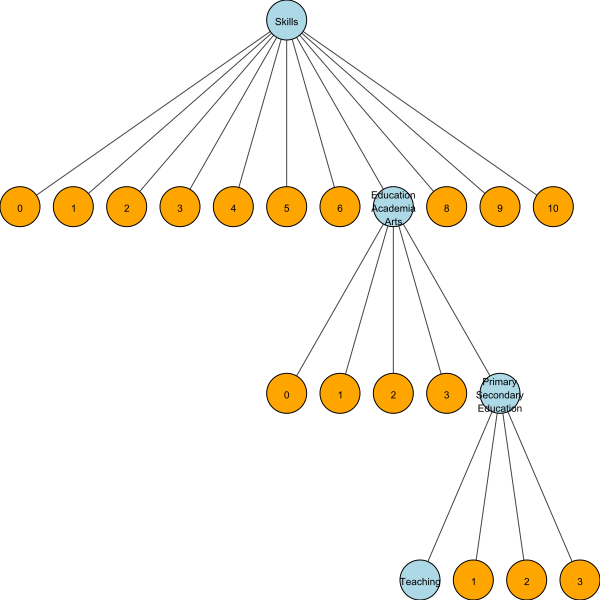

In [4]:
# example illustrating the hierarchical nature of the taxonomy
"""
This simple visualization shows how the skill "assist students with their enrolment" that lives within the cluster 
"Teaching" in the third layer of the taxonomy, is connected to the clusters of skills in the higher layers of the
taxonomy. 
"""
example_g = Graph([(0,1), (0,2), (0,3), (0,4), (0,5), (0,6), (0,7), (0,8), (0,9), (0,10), (0,11),
                  (8,12), (8,13), (8,14), (8,15), (8,16), (16,17), (16,18), (16,19), (16,20)])

example_g.vs["name"] = ["Skills","0", "1", "2", "3", "4", "5", "6", "Education\nAcademia\nArts", "8",
                        "9", "10", "0", "1", "2", "3", "Primary\nSecondary\nEducation", "Teaching",
                        "1", "2", "3"]
layout = example_g.layout_reingold_tilford(root=0)

visual_style = {}
visual_style["vertex_size"] = 40
visual_style["vertex_label"] = example_g.vs["name"]
visual_style["layout"]= layout
visual_style["vertex_label_size"] = 10
visual_style["vertex_label_distance"] = 2
visual_style["vertex_color"] = ["lightblue", "orange", "orange", "orange", "orange", "orange", 
                                "orange", "orange", "lightblue", "orange", "orange", "orange", 
                                "orange","orange","orange","orange","lightblue","lightblue","orange", "orange", "orange"]

igraph.plot(example_g, **visual_style)